# LAB08-지도학습ㅣ예측ㅣPBT - 과제지시서

## 과제 개요
당신은 프랜차이즈 본사 데이터팀에 신입 데이터 분석가로 입사했다.

마케팅팀에서는 다음과 같은 질문을 던진다.
"광고비도 쓰고, 날씨도 보고, 주말도 고려해서 모델을 만들었는데요. 왜 분석 보고서에서는 좋아 보이는데, 실제 매출 예측에는 잘 안 맞는 걸까요?"

당신의 첫 업무는:
- 하루 매출 예측 모델을 만들고
- 왜 단순 선형회귀는 위험한지
- 규제 회귀는 무엇을 통제하는지
- 어떤 모델이 가장 실무적으로 신뢰할 수 있는지

를 분석 보고서 형태로 설명하는 것이다.

**이번 PBT의 목표는 "가장 성능이 좋은 모델을 찾는 것"이 아니라, "실무에서 과적합되지 않는 모델을 합리적으로 선택하고 설명하는 것"이다.**

## 준비작업

### [1] 패키지 가져오기

In [41]:
# 수업용 라이브러리 (데이터셋 로드)
from hossam import *

# 파이썬 기본 라이브러리
from pandas import DataFrame, concat, get_dummies
import numpy as np
from itertools import combinations

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sb

# 통계 라이브러리
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova
from scipy.stats import (
    normaltest,
    bartlett,
    levene,
    ttest_ind,
    pearsonr,
    spearmanr,
    shapiro,
    jarque_bera,
    t,
    f,
)

# 머신러닝 라이브러리
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

# 학습모델
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor,
)

# 성능 평가 지표 모듈
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

### [2] 데이터 가져오기

In [42]:
origin = load_data("restaurant_sales")
origin.head()

어느 식당의 1년간 일별 매출을 기록한 데이터로, 매출액을 종속변수로 하고 방문객 수, 객단가, 광고비, 날씨, 요일, 식당 유형 등의 정보를 포함함.

컬럼명           변수 타입    데이터 성격    설명
---------------  -----------  -------------  -------------------------------------------------------
date             날짜         시계열 인덱스  관측 날짜 (1년, 일 단위)
sales            연속형       수치           일 매출액 (종속변수). 이상치·왜도 존재 → 로그 변환 대상
visitors         연속형       수치           일 방문객 수. 매출과 강한 양의 관계
avg_price        연속형       수치           평균 객단가. 양의 왜도 → 로그 변환 권장
marketing_cost   연속형       수치           일 광고비 지출. 이상치·결측치 포함
delivery_ratio   연속형       비율           배달 매출 비중 (0~1). 비선형 효과 가능
rain_mm          연속형       수치           일 강수량(mm). 일부 결측치 존재
temperature      연속형       수치           일 평균 기온(℃). 계절성 반영
holiday          명목형       이진           공휴일 여부 (0=평일, 1=공휴일)
weekend          명목형       이진           주말 여부 (0=평일, 1=주말)
restaurant_type  명목형       범주           식당 유형 (한식/중식/양식/카페) → 원핫인코딩 필요



,date,sales,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday,weekend,restaurant_type
0,2024-01-01,10525760,122,14490,9900.0,0.48,6.0,5.2,0,0,한식
1,2024-01-02,8931390,106,11880,9400.0,0.48,7.0,11.1,0,0,중식
2,2024-01-03,12654970,120,18010,5800.0,0.43,12.4,12.9,1,0,한식
3,2024-01-04,9650090,115,11160,6300.0,0.41,6.6,12.9,0,0,중식
4,2024-01-05,9951380,124,15480,5400.0,0.51,8.0,11.0,0,0,카페


### [3] 데이터 타입 변환 + 인덱스 설정

In [43]:
df1 = origin.astype(
    {"restaurant_type": "category", "holiday": "category", "weekend": "category"}
)
df1.set_index("date", inplace=True)
display(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-01-01 to 2024-12-30
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sales            365 non-null    int64   
 1   visitors         365 non-null    int64   
 2   avg_price        365 non-null    int64   
 3   marketing_cost   359 non-null    float64 
 4   delivery_ratio   365 non-null    float64 
 5   rain_mm          359 non-null    float64 
 6   temperature      365 non-null    float64 
 7   holiday          365 non-null    category
 8   weekend          365 non-null    category
 9   restaurant_type  365 non-null    category
dtypes: category(3), float64(4), int64(3)
memory usage: 24.3 KB


None

,sales,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday,weekend,restaurant_type
date,,,,,,,,,,
2024-01-01,10525760,122,14490,9900.0,0.48,6.0,5.2,0,0,한식
2024-01-02,8931390,106,11880,9400.0,0.48,7.0,11.1,0,0,중식
2024-01-03,12654970,120,18010,5800.0,0.43,12.4,12.9,1,0,한식
2024-01-04,9650090,115,11160,6300.0,0.41,6.6,12.9,0,0,중식
2024-01-05,9951380,124,15480,5400.0,0.51,8.0,11.0,0,0,카페


## 미션 1. 이 데이터를 그대로 쓰면 어떤 문제가 생길까?

데이터의 품질을 점검하시오.

### [1] 결측치 확인

#### (1) 결측치 수 측정

In [44]:
n = len(df1)
missing_df = DataFrame({"missing_count": df1.isnull().sum()})
missing_df["missing_ratio"] = missing_df["missing_count"] / n
display(missing_df)

,missing_count,missing_ratio
sales,0,0.000000
visitors,0,0.000000
avg_price,0,0.000000
marketing_cost,6,0.016438
delivery_ratio,0,0.000000
rain_mm,6,0.016438
temperature,0,0.000000
holiday,0,0.000000
weekend,0,0.000000
restaurant_type,0,0.000000


#### (2) 독립검정 t-test 함수 정의

In [45]:
def hs_ttest_ind(x_data, y_data):
    # 정규성 판별
    _, p1 = normaltest(x_data)
    _, p2 = normaltest(y_data)
    normal_dist = p1 > 0.05 and p2 > 0.05

    # 등분산성 판별
    if normal_dist:
        method_name = "Bartlett"
        s, p = bartlett(x_data, y_data)
    else:
        method_name = "Levene"
        s, p = levene(x_data, y_data)

    equal_var = p > 0.05

    # 독립표본 t-검정 수행
    alternative: list = ["two-sided", "less", "greater"]
    result: list = []
    fmt: str = "μ(x) {0} μ(y)"

    for a in alternative:
        s, p = ttest_ind(x_data, y_data, equal_var=equal_var, alternative=a)
        n = "t-test_ind" if equal_var else "Welch's t-test"

        # 검정 결과 해석
        itp = None
        if a == "two-sided":
            itp = fmt.format("==" if p > 0.05 else "!=")
        elif a == "less":
            itp = fmt.format(">=" if p > 0.05 else "<")
        else:
            itp = fmt.format("<=" if p > 0.05 else ">")

        result.append(
            {
                "test": n,
                "alternative": a,
                "interpretation": itp,
                "normaltest": normal_dist,
                method_name: equal_var,
                n: round(s, 3),
                "p-value": round(p, 4),
                "H0": p > 0.05,
                "H1": p <= 0.05,
            }
        )

    rdf = DataFrame(result)
    rdf.set_index(["test", "alternative"], inplace=True)
    return rdf

#### (3) marketing_cost 삭제 전후의 종속변수 확인

In [46]:
df_temp = df1.dropna(subset=["marketing_cost"])
hs_ttest_ind(origin["sales"], df_temp["sales"])

interpretation  normaltest  Levene  t-test_ind  \
test       alternative                                                  
t-test_ind two-sided     μ(x) == μ(y)       False    True      -0.041   
           less          μ(x) >= μ(y)       False    True      -0.041   
           greater       μ(x) <= μ(y)       False    True      -0.041   

                        p-value    H0     H1  
test       alternative                        
t-test_ind two-sided     0.9673  True  False  
           less          0.4836  True  False  
           greater       0.5164  True  False

#### (4) rain_mm 삭제 전후의 종속변수 확인

In [47]:
df_temp = df1.dropna(subset=["rain_mm"])
df1_target = df1["sales"]
df_temp_target = df_temp["sales"]
hs_ttest_ind(df1_target, df_temp_target)

interpretation  normaltest  Levene  t-test_ind  \
test       alternative                                                  
t-test_ind two-sided     μ(x) == μ(y)       False    True       0.147   
           less          μ(x) >= μ(y)       False    True       0.147   
           greater       μ(x) <= μ(y)       False    True       0.147   

                        p-value    H0     H1  
test       alternative                        
t-test_ind two-sided     0.8830  True  False  
           less          0.5585  True  False  
           greater       0.4415  True  False

#### (5) 모든 결측치 일괄 삭제 전후의 종속변수 확인

In [48]:
df_temp = df1.dropna()
df1_target = df1["sales"]
df_temp_target = df_temp["sales"]
hs_ttest_ind(df1_target, df_temp_target)

interpretation  normaltest  Levene  t-test_ind  \
test       alternative                                                  
t-test_ind two-sided     μ(x) == μ(y)       False    True       0.107   
           less          μ(x) >= μ(y)       False    True       0.107   
           greater       μ(x) <= μ(y)       False    True       0.107   

                        p-value    H0     H1  
test       alternative                        
t-test_ind two-sided     0.9144  True  False  
           less          0.5428  True  False  
           greater       0.4572  True  False

### [2] 결측치 삭제

In [49]:
df2 = df1.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sales            353 non-null    int64   
 1   visitors         353 non-null    int64   
 2   avg_price        353 non-null    int64   
 3   marketing_cost   353 non-null    float64 
 4   delivery_ratio   353 non-null    float64 
 5   rain_mm          353 non-null    float64 
 6   temperature      353 non-null    float64 
 7   holiday          353 non-null    category
 8   weekend          353 non-null    category
 9   restaurant_type  353 non-null    category
dtypes: category(3), float64(4), int64(3)
memory usage: 23.5 KB


### [3] 이상치 확인

#### (1) 이상치 확인 함수

In [50]:
def hs_outlier_table(data: DataFrame):
    fields = data.select_dtypes(include=np.number).columns
    result = []

    for f in fields:
        # 사분위수
        q1 = data[f].quantile(q=0.25)
        q2 = data[f].quantile(q=0.5)
        q3 = data[f].quantile(q=0.75)
        min_value = data[f].min()
        max_value = data[f].max()

        # 이상치 경계 (Tukey's fences)
        iqr = q3 - q1
        down = q1 - 1.5 * iqr
        up = q3 + 1.5 * iqr

        # 왜도
        skew = data[f].skew()

        # 이상치 개수 및 비율
        outlier_count = ((data[f] < down) | (data[f] > up)).sum()
        outlier_rate = (outlier_count / len(data)) * 100

        # 분포 특성 판정 (왜도 기준)
        abs_skew = abs(skew)
        if abs_skew < 0.5:
            dist = "거의 대칭"
        elif abs_skew < 1.0:
            if skew > 0:
                dist = "약한 우측 꼬리"
            else:
                dist = "약한 좌측 꼬리"
        elif abs_skew < 2.0:
            if skew > 0:
                dist = "중간 우측 꼬리"
            else:
                dist = "중간 좌측 꼬리"
        else:
            if skew > 0:
                dist = "극단 우측 꼬리"
            else:
                dist = "극단 좌측 꼬리"

        # 로그변환 필요성 판정
        if abs_skew < 0.5:
            log_need = "낮음"
        elif abs_skew < 1.0:
            log_need = "중간"
        else:
            log_need = "높음"

        iq = {
            "field": f,
            "q1": q1,
            "q2": q2,
            "q3": q3,
            "iqr": iqr,
            "up": up,
            "down": down,
            "min": min_value,
            "max": max_value,
            "outlier_count": outlier_count,
            "outlier_rate": outlier_rate,
            "skew": skew,
            "dist": dist,
            "log_need": log_need,
        }
        result.append(iq)

    return DataFrame(result).set_index("field")

#### (2) 연속형 변수에 대한 이상치 확인

In [51]:
outlier = hs_outlier_table(df2)
outlier

,q1,q2,q3,iqr,up,down,min,max,outlier_count,outlier_rate,skew,dist,log_need
field,,,,,,,,,,,,,
sales,9620430.00,12203340.00,16828290.00,7207860.00,2.764008e+07,-1191360.000,5972790.00,38585880.00,10,2.832861,1.256981,중간 우측 꼬리,높음
visitors,113.00,120.00,126.00,13.00,1.455000e+02,93.500,83.00,151.00,6,1.699717,-0.014914,거의 대칭,낮음
avg_price,12480.00,15340.00,17550.00,5070.00,2.515500e+04,4875.000,6330.00,27280.00,5,1.416431,0.471286,거의 대칭,낮음
marketing_cost,4500.00,6800.00,10500.00,6000.00,1.950000e+04,-4500.000,1400.00,51700.00,12,3.399433,2.628738,극단 우측 꼬리,높음
delivery_ratio,0.36,0.45,0.53,0.17,7.850000e-01,0.105,0.17,0.77,0,0.000000,0.064028,거의 대칭,낮음
rain_mm,2.10,4.60,7.60,5.50,1.585000e+01,-6.150,0.00,20.00,8,2.266289,1.117849,중간 우측 꼬리,높음
temperature,-0.40,10.00,20.50,20.90,5.185000e+01,-31.750,-10.40,29.50,0,0.000000,0.011906,거의 대칭,낮음


## 미션 2. 어떤 변수를 분석에 사용해야 할까?

연속형 변수와 명목형 변수가 각각 종속변수에 대해 의미있는 변수인지 확인하시오.

### [1] 명목형 변수 anova

#### (1) anova 분석 함수

In [52]:
def hs_oneway_anova(data: DataFrame, dv: str, between: str, alpha: float = 0.05):
    # 결측치 제거
    df_filtered = data[[dv, between]].dropna()

    # 정규성 검정
    group_names = sorted(df_filtered[between].unique())
    normality_satisfied = True

    for group in group_names:
        group_values = df_filtered[df_filtered[between] == group][dv].dropna()
        if len(group_values) > 0:
            s, p = normaltest(group_values)
            if p <= alpha:
                normality_satisfied = False
                break

    # 등분산성 검정
    group_data_dict = {}
    for group in group_names:
        group_data_dict[group] = (
            df_filtered[df_filtered[between] == group][dv].dropna().values
        )

    if len(group_names) > 1:
        if normality_satisfied:
            s, p = bartlett(*group_data_dict.values())
            en = "Bartlett"
        else:
            s, p = levene(*group_data_dict.values())
            en = "Levene"

        equal_var_satisfied = p > alpha
    else:
        equal_var_satisfied = True

    # ANOVA 수행
    anova_df: DataFrame
    anova_method: str

    if equal_var_satisfied:
        anova_method = "ANOVA"
        anova_df = anova(data=df_filtered, dv=dv, between=between)
    else:
        anova_method = "Welch"
        anova_df = welch_anova(data=df_filtered, dv=dv, between=between)

    # 결과에 메타정보 추가
    anova_df.insert(1, "normality", normality_satisfied)
    anova_df.insert(2, en, equal_var_satisfied)
    anova_df[anova_method] = (
        anova_df["p-unc"] <= alpha if "p-unc" in anova_df.columns else False
    )

    return anova_df

#### (2) 단일 변수(restaurant_type)이 매출에 영향을 주는지 확인

In [53]:
hs_oneway_anova(df2, dv="sales", between="restaurant_type")

,Source,normality,Levene,ddof1,ddof2,F,p-unc,np2,ANOVA
0,restaurant_type,False,True,3,349,0.208264,0.890657,0.001787,False


#### (3) 모든 명목형 변수에 대해 매출에 영향을 주는 변수인지 일괄 확인

In [54]:
anova_df = None
fields = df2.dtypes[df2.dtypes == "category"].index.tolist()

for f in fields:
    anova_result = hs_oneway_anova(df2, dv="sales", between=f)

    if anova_df is None:
        anova_df = anova_result
    else:
        anova_df = concat([anova_df, anova_result], ignore_index=True)

anova_df

,Source,normality,Levene,ddof1,ddof2,F,p-unc,np2,Welch,ANOVA
0,holiday,False,False,1,152.174741,256.187649,1.953192e-34,0.513450,True,NaN
1,weekend,False,False,1,129.568243,299.612481,1.677095e-35,0.559832,True,NaN
2,restaurant_type,False,True,3,349.000000,0.208264,8.906571e-01,0.001787,NaN,False


### [2] 종속변수를 제외한 연속형 변수끼리의 상관분석

#### (1) 쌍별 상관분석 함수

In [55]:
def hs_corr_pairwise(data):
    alpha = 0.05
    z_thresh = 3.0
    min_n = 8

    cols = data.select_dtypes(include=[np.number]).columns.tolist()

    if len(cols) < 2:
        raise ValueError("숫자형 컬럼이 두 개 이상 있어야 상관분석 가능")

    # z-score 기반 이상치 유무 계산
    z_outlier_flags = {}
    for c in cols:
        col = data[c].dropna()
        if col.std(ddof=1) == 0:
            z_outlier_flags[c] = False
            continue

        z = (col - col.mean()) / col.std(ddof=1)
        z_outlier_flags[c] = (z.abs() > z_thresh).any()

    rows = []
    for a, b in combinations(cols, 2):
        pair_df = data[[a, b]].dropna()

        if len(pair_df) < min_n:
            rows.append(
                {
                    "var_a": a,
                    "var_b": b,
                    "n": len(pair_df),
                    "linearity": False,
                    "outlier_flag": True,
                    "chosen": None,
                    "corr": np.nan,
                    "pval": np.nan,
                    "significant": False,
                    "strength": "no correlation",
                }
            )
            continue

        x = pair_df[a]
        y = pair_df[b]

        # 선형성 검정
        linearity_ok = False
        try:
            X_const = sm.add_constant(x)
            model = sm.OLS(y, X_const).fit()
            reset = linear_reset(model)
            linearity_ok = reset.pvalue > alpha
        except Exception:
            linearity_ok = False

        outlier_flag = bool(
            z_outlier_flags.get(a, False) or z_outlier_flags.get(b, False)
        )

        try:
            if linearity_ok and not outlier_flag:
                chosen = "pearson"
                corr_val, pval = pearsonr(x, y)
            else:
                chosen = "spearman"
                corr_val, pval = spearmanr(x, y)
        except Exception:
            chosen = None
            corr_val, pval = np.nan, np.nan

        significant = False if np.isnan(pval) else pval <= alpha
        abs_r = abs(corr_val) if not np.isnan(corr_val) else 0

        if abs_r > 0.7:
            strength = "strong"
        elif abs_r > 0.3:
            strength = "medium"
        elif abs_r > 0:
            strength = "weak"
        else:
            strength = "no correlation"

        rows.append(
            {
                "var_a": a,
                "var_b": b,
                "n": len(pair_df),
                "linearity": linearity_ok,
                "outlier_flag": outlier_flag,
                "chosen": chosen,
                "corr": corr_val,
                "pval": pval,
                "significant": significant,
                "strength": strength,
            }
        )

    result_df = DataFrame(rows)

    # 상관행렬 생성
    corr_matrix = DataFrame(np.nan, index=cols, columns=cols)

    for c in cols:
        corr_matrix.loc[c, c] = 1.0

    if not result_df.empty:
        for _, row in result_df.iterrows():
            a, b, corr_val = row["var_a"], row["var_b"], row["corr"]
            corr_matrix.loc[a, b] = corr_val
            corr_matrix.loc[b, a] = corr_val

    return result_df, corr_matrix

In [56]:
corr, matric = hs_corr_pairwise(df2.drop("sales", axis=1))
display(corr)
display(matric)

,var_a,var_b,n,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,visitors,avg_price,353,False,True,spearman,0.046590,0.382820,False,weak
1,visitors,marketing_cost,353,True,True,spearman,0.023626,0.658221,False,weak
2,visitors,delivery_ratio,353,True,True,spearman,0.105643,0.047326,True,weak
3,visitors,rain_mm,353,True,True,spearman,0.045073,0.398516,False,weak
4,visitors,temperature,353,True,True,spearman,-0.020993,0.694269,False,weak
5,avg_price,marketing_cost,353,False,True,spearman,0.056561,0.289249,False,weak
6,avg_price,delivery_ratio,353,True,True,spearman,-0.018357,0.731073,False,weak
7,avg_price,rain_mm,353,True,True,spearman,0.094220,0.077078,False,weak
8,avg_price,temperature,353,True,True,spearman,-0.008404,0.874977,False,weak
9,marketing_cost,delivery_ratio,353,True,True,spearman,-0.008708,0.870501,False,weak


,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature
visitors,1.000000,0.046590,0.023626,0.105643,0.045073,-0.020993
avg_price,0.046590,1.000000,0.056561,-0.018357,0.094220,-0.008404
marketing_cost,0.023626,0.056561,1.000000,-0.008708,-0.011931,-0.030441
delivery_ratio,0.105643,-0.018357,-0.008708,1.000000,0.049365,0.009486
rain_mm,0.045073,0.094220,-0.011931,0.049365,1.000000,0.055064
temperature,-0.020993,-0.008404,-0.030441,0.009486,0.055064,1.000000


## 미션 3. 머신러닝에 적합한 데이터 만들기

### [1] ANOVA 결과 반영

In [57]:
# 영향을 주지 않는 변수 제거
df3 = df2.drop("restaurant_type", axis=1)
display(df3.head())

,sales,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday,weekend
date,,,,,,,,,
2024-01-01,10525760,122,14490,9900.0,0.48,6.0,5.2,0,0
2024-01-02,8931390,106,11880,9400.0,0.48,7.0,11.1,0,0
2024-01-03,12654970,120,18010,5800.0,0.43,12.4,12.9,1,0
2024-01-04,9650090,115,11160,6300.0,0.41,6.6,12.9,0,0
2024-01-05,9951380,124,15480,5400.0,0.51,8.0,11.0,0,0


### [2] 로그 변환

In [58]:
# 변수 로그 변환
log_fields = outlier[outlier["log_need"] != "낮음"].index.tolist()

for f in log_fields:
    df3[f] = np.log1p(df3[f])

# 변환후 데이터 분포 확인
outlier_after = hs_outlier_table(df3)
display(outlier_after)

,q1,q2,q3,iqr,up,down,min,max,outlier_count,outlier_rate,skew,dist,log_need
field,,,,,,,,,,,,,
sales,16.079400,16.317220,16.638572,0.559172,17.477331,15.240641,15.602725,17.468397,0,0.000000,0.385373,거의 대칭,낮음
visitors,113.000000,120.000000,126.000000,13.000000,145.500000,93.500000,83.000000,151.000000,6,1.699717,-0.014914,거의 대칭,낮음
avg_price,12480.000000,15340.000000,17550.000000,5070.000000,25155.000000,4875.000000,6330.000000,27280.000000,5,1.416431,0.471286,거의 대칭,낮음
marketing_cost,8.412055,8.824825,9.259226,0.847171,10.529982,7.141299,7.244942,10.853232,1,0.283286,0.096459,거의 대칭,낮음
delivery_ratio,0.360000,0.450000,0.530000,0.170000,0.785000,0.105000,0.170000,0.770000,0,0.000000,0.064028,거의 대칭,낮음
rain_mm,1.131402,1.722767,2.151762,1.020360,3.682302,-0.399138,0.000000,3.044522,0,0.000000,-0.296860,거의 대칭,낮음
temperature,-0.400000,10.000000,20.500000,20.900000,51.850000,-31.750000,-10.400000,29.500000,0,0.000000,0.011906,거의 대칭,낮음


### [3] 더미변수 처리

In [59]:
df4 = get_dummies(df3, columns=["holiday", "weekend"], drop_first=False, dtype="int")
df4.head()

,sales,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday_0,holiday_1,weekend_0,weekend_1
date,,,,,,,,,,,
2024-01-01,16.169336,122,14490,9.200391,0.48,1.945910,5.2,1,0,1,0
2024-01-02,16.005083,106,11880,9.148571,0.48,2.079442,11.1,1,0,1,0
2024-01-03,16.353561,120,18010,8.665786,0.43,2.595255,12.9,0,1,1,0
2024-01-04,16.082478,115,11160,8.748464,0.41,2.028148,12.9,1,0,1,0
2024-01-05,16.113222,124,15480,8.594339,0.51,2.197225,11.0,1,0,1,0


### [4] 전처리 완료 데이터셋 저장

In [60]:
df4.to_excel("restaurant_sales_preprocessed.xlsx")

## 미션 4. 어떤 모델이 보고서만 좋아 보일까?

### [1] 훈련, 검증 데이터 분리

In [61]:
df = df4.copy()
yname = "sales"
x = df.drop(yname, axis=1)
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 10), (89, 10), (264,), (89,))

### [2] 다중선형회귀

#### (1) VIF 필터링 클래스 작성하기

In [62]:
from IPython.display import display


class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10.0, check_cols=None):
        self.threshold = threshold
        self.check_cols = check_cols

    def _compute_vifs(self, X: DataFrame):
        exog = sm.add_constant(X, prepend=True)
        vifs = {}

        for i, col in enumerate(X.columns):
            try:
                vifs[col] = float(variance_inflation_factor(exog.values, i + 1))
            except Exception:
                vifs[col] = float("inf")

        vdf = DataFrame(vifs.items(), columns=["Variable", "VIF"])
        return vdf.sort_values("VIF", ascending=False)

    def fit(self, X, y=None):
        df = X.copy().dropna()
        self.vif_cols_ = self.check_cols if self.check_cols else df.columns.tolist()
        X_vif = df[self.vif_cols_].copy()
        self.drop_cols_ = []
        i = 0

        while True:
            if X_vif.shape[1] == 0:
                break

            print(f"\nVIF 제거 반복 {i+1}회차 ====================")
            vdf = self._compute_vifs(X_vif)
            max_vif = vdf.iloc[0]["VIF"]
            max_col = vdf.iloc[0]["Variable"]

            if max_vif <= self.threshold:
                print(
                    "모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 {0}개.".format(
                        i
                    )
                )
                break

            X_vif = X_vif.drop(columns=[max_col])
            self.drop_cols_.append(max_col)
            print(f"제거된 변수: {max_col} (VIF={max_vif:.2f})")
            i += 1

        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols_, errors="ignore")

#### (2) 선형회귀모델 적합

In [63]:
%%time
linear_pipe = Pipeline(
    [
        (
            "vif_selector",
            VIFSelector(
                check_cols=[
                    "visitors",
                    "avg_price",
                    "marketing_cost",
                    "delivery_ratio",
                    "rain_mm",
                    "temperature",
                ]
            ),
        ),
        (
            "scaler",
            StandardScaler(),
        ),
        ("model", LinearRegression(n_jobs=-1)),
    ]
)

linear_param_grid = {}

linear_gs = GridSearchCV(
    estimator=linear_pipe, param_grid=linear_param_grid, cv=5, scoring="r2", n_jobs=-1
)
linear_gs.fit(x_train, y_train)

linear_estimator = linear_gs.best_estimator_
linear_estimator

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 


VIF 제거 반복 1회차 ====================

VIF 제거 반복 1회차 ====================

VIF 제거 반복 1회차 ====================

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.
CPU times: user 27.7 ms, sys: 39.8 ms, total: 67.5 ms
Wall time: 1.72 s


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vif_selector', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,threshold,10.0
,check_cols,"['visitors', 'avg_price', ...]"
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True


#### (3) 선형회귀 모형의 성능평가지표

In [64]:
y_pred = linear_estimator.predict(x_test)

linear_result_df = DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MAE)": mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)": mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차(MPE)": np.mean((y_test - y_pred) / y_test * 100),
    },
    index=["Linear"],
)

linear_result_df

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
Linear,0.70945,0.156402,0.041565,0.203874,0.009521,0.224936


### [3] 릿지회귀

In [65]:
%%time
ridge_pipe = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=52))])

ridge_param_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}

ridge_gs = GridSearchCV(estimator=ridge_pipe, param_grid=ridge_param_grid, cv=5, scoring="r2", n_jobs=-1)
ridge_gs.fit(x_train, y_train)

ridge_estimator = ridge_gs.best_estimator_

# 성능평가
y_pred = ridge_estimator.predict(x_test)

ridge_result_df = DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MAE)": mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)": mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차(MPE)": np.mean((y_test - y_pred) / y_test * 100),
    },
    index=["Ridge"],
)

display(ridge_result_df)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
Ridge,0.708035,0.156232,0.041767,0.20437,0.00951,0.221685


CPU times: user 25.7 ms, sys: 4.41 ms, total: 30.2 ms
Wall time: 1.03 s


### [4] 라쏘회귀

In [66]:
%%time
lasso_pipe = Pipeline([("scaler", StandardScaler()), ("model", Lasso(random_state=52))])

lasso_param_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}

lasso_gs = GridSearchCV(estimator=lasso_pipe, param_grid=lasso_param_grid, cv=5, scoring="r2", n_jobs=-1)
lasso_gs.fit(x_train, y_train)

lasso_estimator = lasso_gs.best_estimator_

# 성능평가
y_pred = lasso_estimator.predict(x_test)

lasso_result_df = DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MAE)": mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)": mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차(MPE)": np.mean((y_test - y_pred) / y_test * 100),
    },
    index=["Lasso"],
)

display(lasso_result_df)

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
Lasso,0.706818,0.155335,0.041941,0.204795,0.009455,0.221226


CPU times: user 19.1 ms, sys: 2.39 ms, total: 21.5 ms
Wall time: 31.2 ms


### [5] 엘라스틱 넷

In [67]:
%%time
en_pipe = Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(random_state=52))])

en_param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10],
    "model__l1_ratio": [0.1, 0.5, 0.9],
}

en_gs = GridSearchCV(estimator=en_pipe, param_grid=en_param_grid, cv=5, scoring="r2", n_jobs=-1)
en_gs.fit(x_train, y_train)

en_estimator = en_gs.best_estimator_

# 성능평가
y_pred = en_estimator.predict(x_test)

en_result_df = DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MAE)": mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)": mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차(MPE)": np.mean((y_test - y_pred) / y_test * 100),
    },
    index=["ElasticNet"],
)

display(en_result_df)

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
ElasticNet,0.70947,0.156122,0.041562,0.203867,0.009504,0.223856


CPU times: user 38 ms, sys: 3.87 ms, total: 41.9 ms
Wall time: 56 ms


### [6] 경사하강법

In [68]:
%%time
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

sgd_pipe = Pipeline([("scaler", StandardScaler()), ("model", SGDRegressor(random_state=52))])

sgd_param_grid = {
    "model__penalty": ["l2", "l1", "elasticnet"],
    "model__alpha": [0.001, 0.01, 0.1],
    "model__l1_ratio": [0.15, 0.5, 0.85],
    "model__learning_rate": ["optimal", "invscaling"],
}

sgd_gs = GridSearchCV(estimator=sgd_pipe, param_grid=sgd_param_grid, cv=5, scoring="r2", n_jobs=-1)
sgd_gs.fit(x_train, y_train)

sgd_estimator = sgd_gs.best_estimator_

# 성능평가
y_pred = sgd_estimator.predict(x_test)

sgd_result_df = DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MAE)": mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)": mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차(MPE)": np.mean((y_test - y_pred) / y_test * 100),
    },
    index=["SGD"],
)

display(sgd_result_df)

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
SGD,0.696874,0.158538,0.043364,0.208239,0.009645,0.253347


CPU times: user 104 ms, sys: 7.32 ms, total: 111 ms
Wall time: 159 ms


### [7] 성능 비교표

In [69]:
diff_df = concat(
    [linear_result_df, ridge_result_df, lasso_result_df, en_result_df, sgd_result_df]
)
diff_df

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
Linear,0.709450,0.156402,0.041565,0.203874,0.009521,0.224936
Ridge,0.708035,0.156232,0.041767,0.204370,0.009510,0.221685
Lasso,0.706818,0.155335,0.041941,0.204795,0.009455,0.221226
ElasticNet,0.709470,0.156122,0.041562,0.203867,0.009504,0.223856
SGD,0.696874,0.158538,0.043364,0.208239,0.009645,0.253347


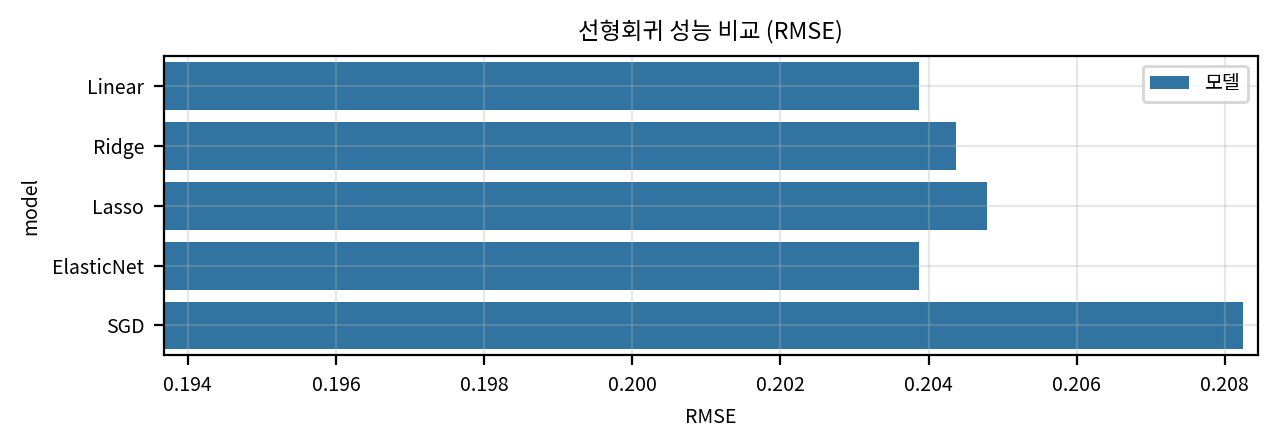

In [70]:
figsize = (1280 / my_dpi, 450 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.barplot(data=diff_df, x="평균오차(RMSE)", y=diff_df.index, label="모델")
ax.set_title("선형회귀 성능 비교 (RMSE)")
ax.set_xlabel("RMSE")
ax.set_ylabel("model")
ax.grid(True, alpha=0.3)
ax.set_xlim(
    diff_df["평균오차(RMSE)"].min() * 0.95, diff_df["평균오차(RMSE)"].max() * 1.001
)

plt.tight_layout()
plt.show()
plt.close()

## 미션 5. 팀에 보고할 '최종 모델'을 하나 고르자

### 과적합 판정 함수

In [71]:
def hs_leanring_cv(
    estimator,
    x,
    y,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
):
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52,
    )

    model_name = estimator.named_steps["model"].__class__.__name__
    print(f"=== Learning Curve: {model_name} ===")

    # neg RMSE → RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지점 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]

    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv

    # 과소적합 기준선
    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))
    std_y = y.std()
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))
    some_threshold = min(rmse_naive, std_y, rmse_r2)

    # 판정 로직
    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = "과소적합 (bias 큼)"
    elif gap_ratio <= 0.8:
        status = "과대적합 (variance 큼)"
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = "일반화 양호"
    elif var_ratio > 0.15:
        status = "데이터 부족 / 분산 큼"
    else:
        status = "판단 유보"

    # 정량 결과 표
    result_df = DataFrame(
        {
            "지표": [
                "Train RMSE",
                "CV RMSE 평균",
                "CV RMSE 표준편차",
                "Train/CV 비율",
                "CV 변동성 비율",
                "판정 결과",
            ],
            "값": [
                final_train,
                final_cv,
                final_std,
                gap_ratio,
                var_ratio,
                status,
            ],
        }
    )
    display(result_df)

    # 학습곡선 시각화
    figsize = (1280 / my_dpi, 720 / my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.lineplot(
        x=train_sizes,
        y=train_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="Train RMSE",
    )

    sb.lineplot(
        x=train_sizes,
        y=cv_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="CV RMSE",
    )

    ax.set_xlabel("훈련 데이터 수", fontsize=8, labelpad=5)
    ax.set_ylabel("RMSE", fontsize=8, labelpad=5)
    ax.set_title("학습곡선 (Learning Curve)", fontsize=12, pad=8)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

### 훈련 모델별 과적합 판정


VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================

VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.

VIF 제거 반복 1회차 ====================

VIF 제거 반복 1회차 ====================

VIF

,지표,값
0,Train RMSE,0.197552
1,CV RMSE 평균,0.203111
2,CV RMSE 표준편차,0.01215
3,Train/CV 비율,0.97263
4,CV 변동성 비율,0.059819
5,판정 결과,판단 유보


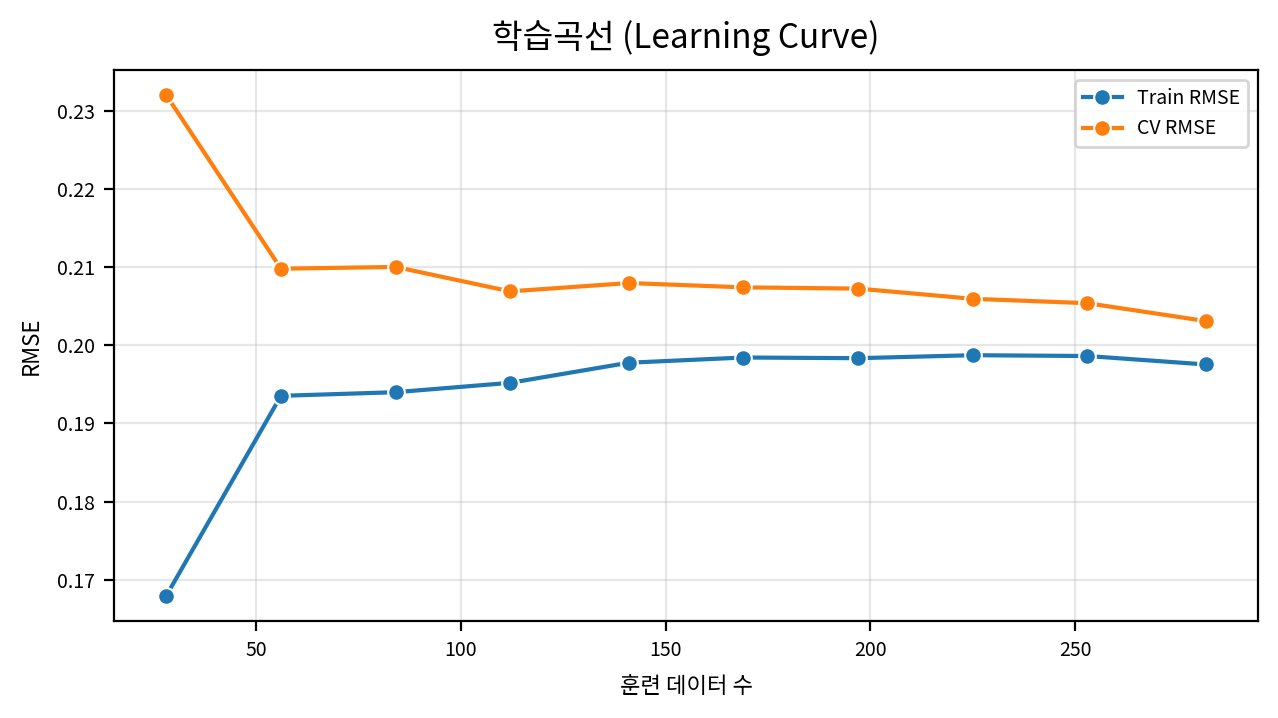

=== Learning Curve: Ridge ===


,지표,값
0,Train RMSE,0.197661
1,CV RMSE 평균,0.203012
2,CV RMSE 표준편차,0.012136
3,Train/CV 비율,0.973641
4,CV 변동성 비율,0.059781
5,판정 결과,판단 유보


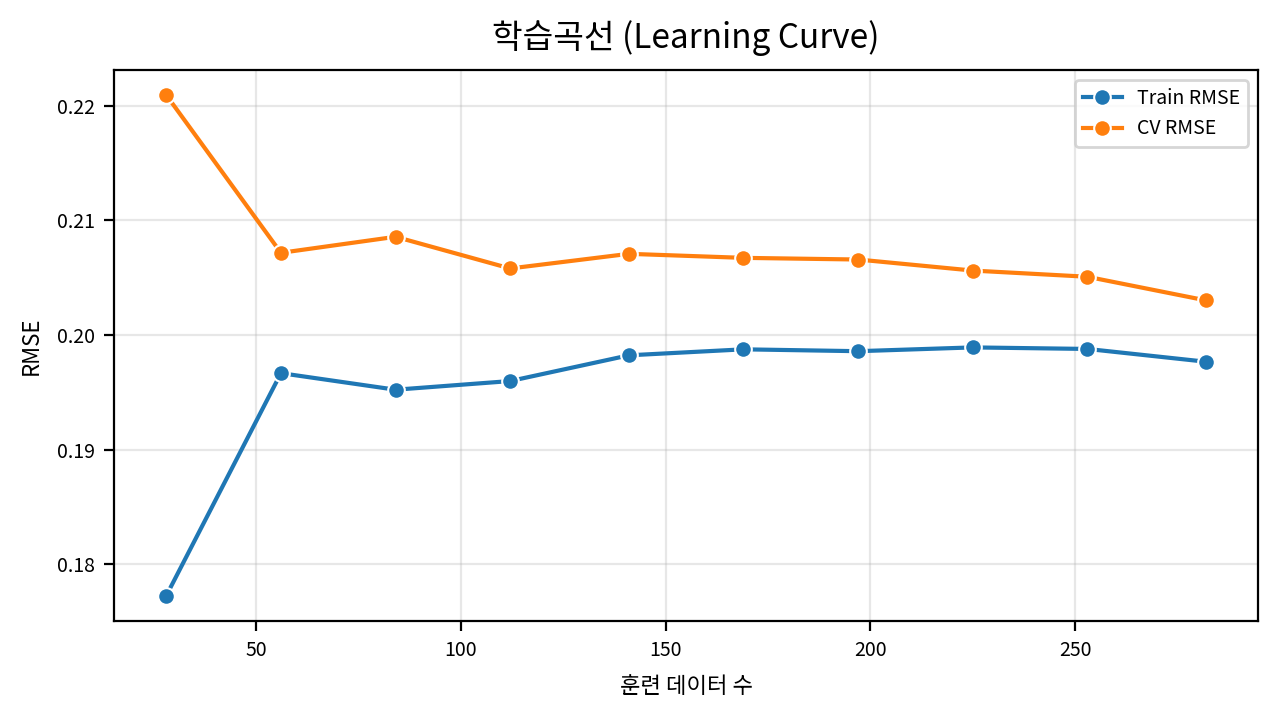

=== Learning Curve: Lasso ===


,지표,값
0,Train RMSE,0.199085
1,CV RMSE 평균,0.20364
2,CV RMSE 표준편차,0.011158
3,Train/CV 비율,0.977635
4,CV 변동성 비율,0.054793
5,판정 결과,판단 유보


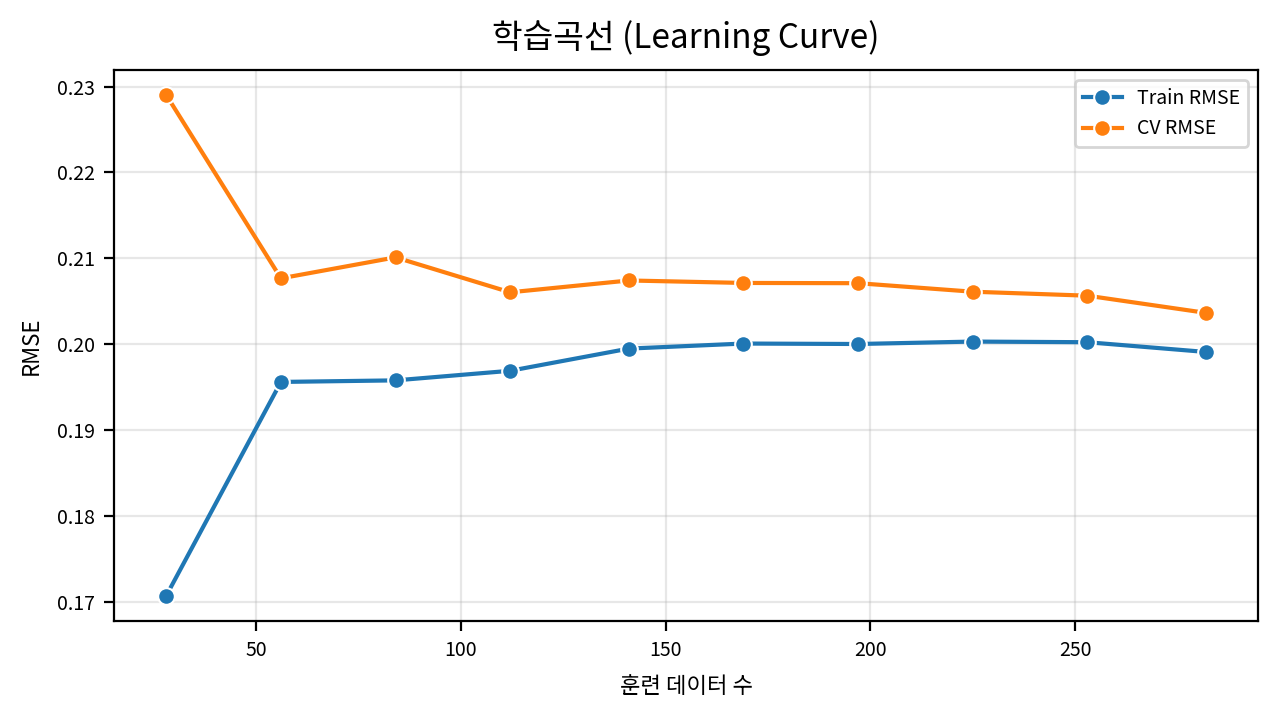

=== Learning Curve: ElasticNet ===


,지표,값
0,Train RMSE,0.197594
1,CV RMSE 평균,0.202956
2,CV RMSE 표준편차,0.012
3,Train/CV 비율,0.973582
4,CV 변동성 비율,0.059127
5,판정 결과,판단 유보


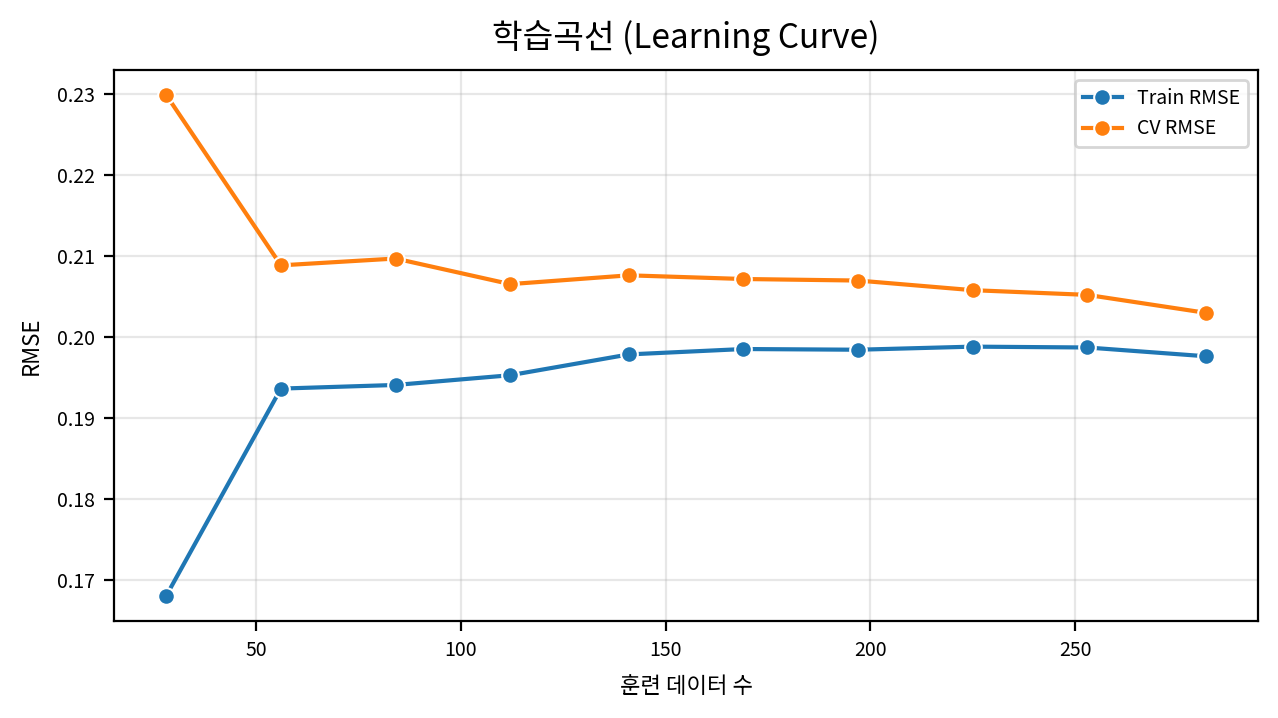

=== Learning Curve: SGDRegressor ===


,지표,값
0,Train RMSE,0.198632
1,CV RMSE 평균,0.203471
2,CV RMSE 표준편차,0.011989
3,Train/CV 비율,0.976219
4,CV 변동성 비율,0.058922
5,판정 결과,판단 유보


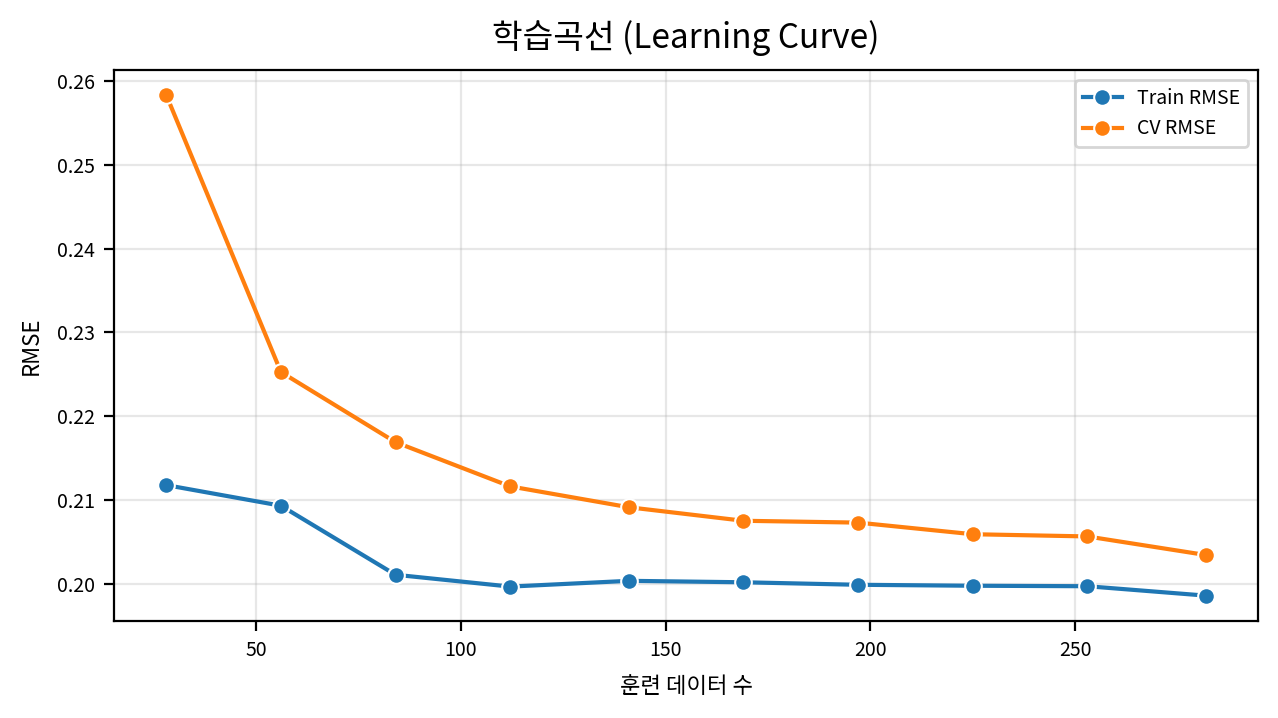

In [72]:
models = [
    linear_estimator,
    ridge_estimator,
    lasso_estimator,
    en_estimator,
    sgd_estimator,
]

for m in models:
    hs_leanring_cv(estimator=m, x=x, y=y)

## 미션 6. 이 모델은 설명 가능한가?

### [1] 선형성

In [73]:
estimator = linear_estimator

rdf = x_train.copy()
rdf["sales"] = y_train
rdf["y_pred"] = estimator.predict(x_train)
rdf["resid"] = rdf[yname] - rdf["y_pred"]
rdf.head()

,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday_0,holiday_1,weekend_0,weekend_1,sales,y_pred,resid
date,,,,,,,,,,,,,
2024-06-11,129,8590,8.987322,0.41,2.028148,14.2,1,0,1,0,16.142334,16.062723,0.079611
2024-06-20,115,22020,8.412055,0.38,2.219203,8.0,1,0,1,0,15.944358,16.126344,-0.181987
2024-08-25,115,14630,9.457279,0.49,2.251292,-2.9,0,1,0,1,16.579528,16.767852,-0.188325
2024-11-22,137,16830,8.810012,0.38,1.193922,0.7,1,0,1,0,16.408428,16.291046,0.117381
2024-12-30,106,13370,8.537192,0.48,2.197225,9.6,1,0,1,0,16.234921,15.955658,0.279263


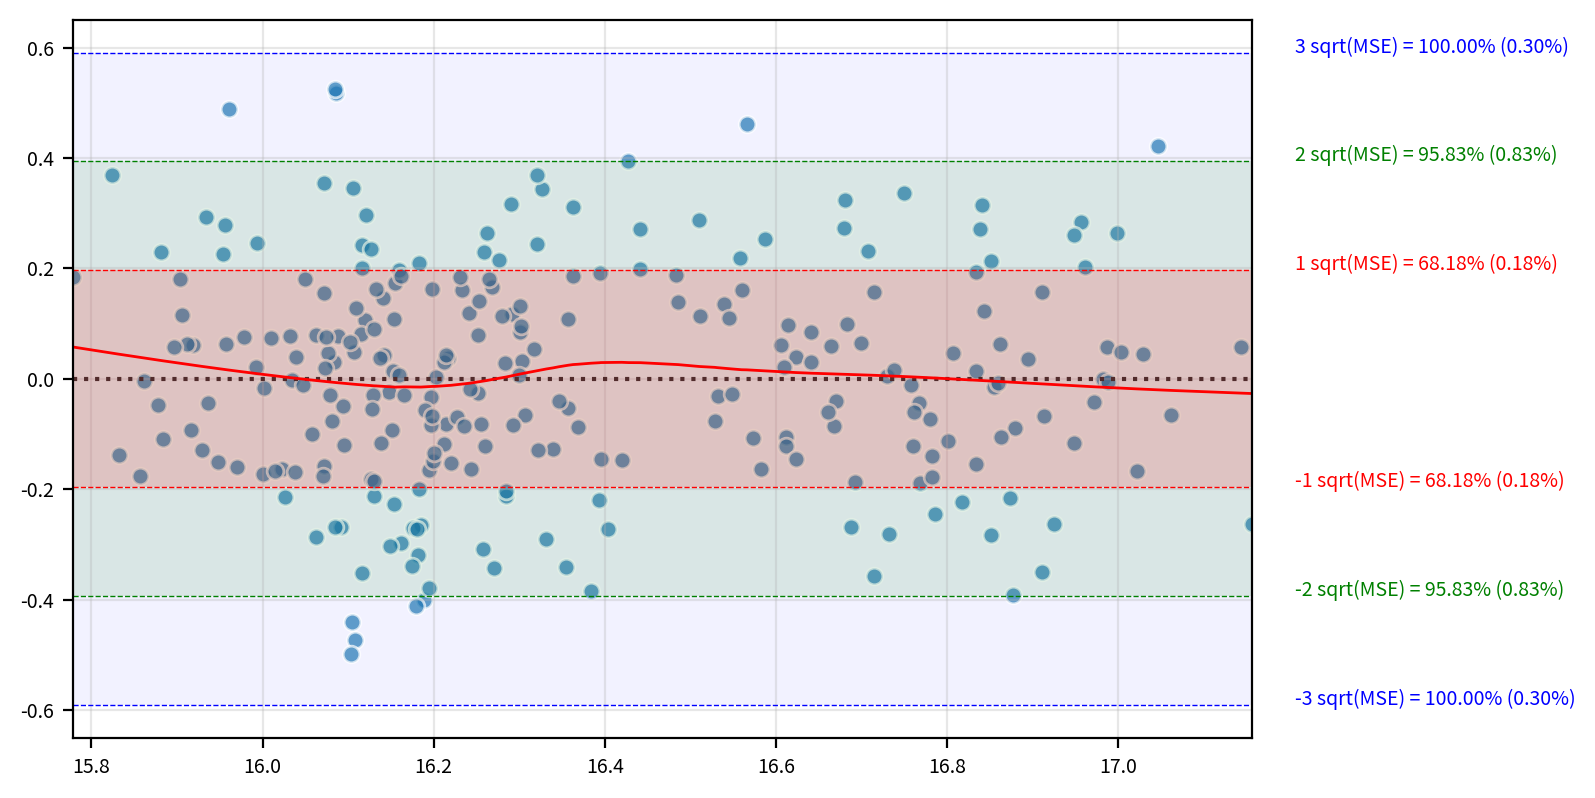

In [74]:
y = rdf[yname].values
y_pred = rdf["y_pred"].values
resid = rdf["resid"].values

figsize = (1600 / my_dpi, 800 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.residplot(
    x=y_pred,
    y=resid,
    lowess=True,
    line_kws={"color": "red", "linewidth": 1},
    scatter_kws={"edgecolor": "white", "alpha": 0.7},
)

mse_val = mean_squared_error(y, y_pred)
mse_sq = np.sqrt(mse_val)

r1 = resid[(resid > -mse_sq) & (resid < mse_sq)].size / resid.size * 100
r2 = resid[(resid > -2 * mse_sq) & (resid < 2 * mse_sq)].size / resid.size * 100
r3 = resid[(resid > -3 * mse_sq) & (resid < 3 * mse_sq)].size / resid.size * 100

mse_r = [r1, r2, r3]
xmin, xmax = ax.get_xlim()

colors = ["red", "green", "blue"]
alphas = [0.15, 0.10, 0.05]

ax.axhspan(-3 * mse_sq, 3 * mse_sq, facecolor=colors[2], alpha=alphas[2], zorder=0)
ax.axhspan(-2 * mse_sq, 2 * mse_sq, facecolor=colors[1], alpha=alphas[1], zorder=1)
ax.axhspan(-mse_sq, mse_sq, facecolor=colors[0], alpha=alphas[0], zorder=2)

for i, c in enumerate(["red", "green", "blue"]):
    ax.axhline(mse_sq * (i + 1), color=c, linestyle="--", linewidth=0.5)
    ax.axhline(mse_sq * (-(i + 1)), color=c, linestyle="--", linewidth=0.5)

target = [68, 95, 99.7]
for i, c in enumerate(["red", "green", "blue"]):
    ax.text(
        s=f"{i+1} sqrt(MSE) = {mse_r[i]:.2f}% ({mse_r[i] - target[i]:.2f}%)",
        x=xmax + 0.05,
        y=(i + 1) * mse_sq,
        color=c,
    )
    ax.text(
        s=f"-{i+1} sqrt(MSE) = {mse_r[i]:.2f}% ({mse_r[i] - target[i]:.2f}%)",
        x=xmax + 0.05,
        y=-(i + 1) * mse_sq,
        color=c,
    )

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### [2] 정규성

In [75]:
residuals = rdf["resid"].values
n = len(residuals)
alpha = 0.05
results = []

# Shapiro-Wilk 검정
if n < 5000:
    try:
        stat_sw, p_sw = shapiro(residuals)
        significant_sw = p_sw <= alpha

        if significant_sw:
            interpretation_sw = f"정규성 위반 (p={p_sw:.4f} <= {alpha})"
        else:
            interpretation_sw = f"정규성 만족 (p={p_sw:.4f} > {alpha})"

        results.append(
            {
                "검정": "Shapiro-Wilk",
                "검정통계량": f"{stat_sw:.4f}",
                "p-value": f"{p_sw:.4f}",
                "유의수준": alpha,
                "정규성_위반": significant_sw,
                "해석": interpretation_sw,
            }
        )
    except Exception as e:
        pass

# Jarque-Bera 검정
try:
    stat_jb, p_jb = jarque_bera(residuals)
    significant_jb = p_jb <= alpha

    if significant_jb:
        interpretation_jb = f"정규성 위반 (p={p_jb:.4f} <= {alpha})"
    else:
        interpretation_jb = f"정규성 만족 (p={p_jb:.4f} > {alpha})"

    results.append(
        {
            "검정": "Jarque-Bera",
            "검정통계량": f"{stat_jb:.4f}",
            "p-value": f"{p_jb:.4f}",
            "유의수준": alpha,
            "정규성_위반": significant_jb,
            "해석": interpretation_jb,
        }
    )
except Exception as e:
    pass

result_df = DataFrame(results)
result_df

,검정,검정통계량,p-value,유의수준,정규성_위반,해석
0,Shapiro-Wilk,0.9970,0.9049,0.05,False,정규성 만족 (p=0.9049 > 0.05)
1,Jarque-Bera,0.8845,0.6426,0.05,False,정규성 만족 (p=0.6426 > 0.05)


### [3] 등분산성

In [76]:
resid = rdf["resid"]
alpha = 0.05
results = []
exog = rdf.drop(columns=[yname, "y_pred", "resid"])
exog = sm.add_constant(exog)

# Breusch-Pagan 검정
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog)
    significant_bp = lm_pvalue <= alpha

    if significant_bp:
        interpretation_bp = f"등분산성 위반 (p={lm_pvalue:.4f} <= {alpha})"
    else:
        interpretation_bp = f"등분산성 만족 (p={lm_pvalue:.4f} > {alpha})"

    results.append(
        {
            "검정": "Breusch-Pagan",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value": f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "등분산성_위반": significant_bp,
            "해석": interpretation_bp,
        }
    )
except Exception as e:
    pass

# White 검정
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_white(resid, exog)
    significant_white = lm_pvalue <= alpha

    if significant_white:
        interpretation_white = f"등분산성 위반 (p={lm_pvalue:.4f} <= {alpha})"
    else:
        interpretation_white = f"등분산성 만족 (p={lm_pvalue:.4f} > {alpha})"

    results.append(
        {
            "검정": "White",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value": f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "등분산성_위반": significant_white,
            "해석": interpretation_white,
        }
    )
except Exception as e:
    pass

result_df = DataFrame(results)
result_df

,검정,검정통계량 (LM),p-value,유의수준,등분산성_위반,해석
0,Breusch-Pagan,5.3636,0.8656,0.05,False,등분산성 만족 (p=0.8656 > 0.05)
1,White,28.5775,0.9287,0.05,False,등분산성 만족 (p=0.9287 > 0.05)


### [4] 독립성

In [77]:
# Durbin-Watson 통계량 계산
dw_stat = durbin_watson(rdf["resid"])
is_autocorrelated = dw_stat < 1.5 or dw_stat > 2.5

if dw_stat < 1.5:
    interpretation = f"DW={dw_stat:.4f} < 1.5 (양의 자기상관)"
elif dw_stat > 2.5:
    interpretation = f"DW={dw_stat:.4f} > 2.5 (음의 자기상관)"
else:
    interpretation = f"DW={dw_stat:.4f} (독립성 가정 만족)"

result_df = DataFrame(
    {
        "검정": ["Durbin-Watson"],
        "검정통계량(DW)": [dw_stat],
        "독립성_위반": [is_autocorrelated],
        "해석": [interpretation],
    }
)

result_df

,검정,검정통계량(DW),독립성_위반,해석
0,Durbin-Watson,1.933538,False,DW=1.9335 (독립성 가정 만족)


## 미션 7. 최종 결과 보고

### [1] 모형 적합도 보고

In [78]:
from scipy.stats import f


# 잔차 분석용 예측값 및 잔차 계산
y_train_pred = estimator.predict(x_train)
resid = y_train - y_train_pred

# Durbin-Watson 통계량 계산
dw = durbin_watson(resid)

# 결정계수 및 조정된 결정계수 계산
xnames = x_train.columns.tolist()
r2 = r2_score(y_train, y_train_pred)
r = np.sqrt(r2)
adj_r2 = 1 - (1 - r2) * (len(y_train) - 1) / (len(y_train) - len(xnames) - 1)

# F-statistic
rowcount = len(x_train)
featurecount = len(xnames)
f_statistic = (r2 / featurecount) / ((1 - r2) / (rowcount - featurecount - 1))

# p-value 계산
p = 1 - f.cdf(f_statistic, featurecount, rowcount - featurecount - 1)

# 결과 데이터프레임 생성
rdf = DataFrame(
    {
        "R": [r],
        "R²": [r2],
        "Adj R²": [adj_r2],
        "F": [f_statistic],
        "p-value": [p],
        "Durbin-Watson": [dw],
    }
)

rdf

,R,R²,Adj R²,F,p-value,Durbin-Watson
0,0.857071,0.734571,0.72408,70.017481,0.0,1.933538


In [ ]:
tpl = "R(%.3f), R²(%.3f), Adj R²(%.3f), 𝐹(%.3f), P-value(%.3f), Durbin-Watson(%.3f)"
tpl % (r, r2, adj_r2, f_statistic, p, dw)

'R(0.857), R²(0.735), Adj R²(0.724), 𝐹(70.017), P-value(0.000), Durbin-Watson(1.934)'

In [80]:
tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %0.3f, p %s 0.05)."

tpl % (
    yname,
    ",".join(xnames),
    "유의하다" if p <= 0.05 else "유의하지 않다",
    len(x_train.columns),
    len(x_train.index) - len(x_train.columns) - 1,
    f_statistic,
    "<=" if p <= 0.05 else ">",
)

'sales에 대하여 visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday_0,holiday_1,weekend_0,weekend_1로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(10,253) = 70.017, p <= 0.05).'

### [2] 독립변수 보고

In [81]:
# 절편과 계수를 하나의 배열로 결합
params = np.append(
    estimator.named_steps["model"].intercept_, estimator.named_steps["model"].coef_
)

# 독립변수에 상수항 추가
design_x = x_train.copy()
design_x = sm.add_constant(design_x)

# 독립변수의 행렬곱
dot = np.dot(design_x.T, design_x)

# 행렬곱의 역행렬
inv = np.linalg.inv(dot)

# 역행렬의 대각선 반환
dia = inv.diagonal()

# 평균제곱오차
predictions = estimator.predict(x_train)
n = design_x.shape[0]
p = design_x.shape[1]
MSE = ((y_train - predictions) ** 2).sum() / (n - p)

# 표준오차
se_b = np.sqrt(MSE * dia)

# t-통계량
ts_b = params / se_b

# p-값
n = design_x.shape[0]
p = design_x.shape[1]
p_values = [2 * (1 - t.cdf(np.abs(i), n - p)) for i in ts_b]

# vif
vif = []
x_con = sm.add_constant(x_train)

for i, v in enumerate(xnames):
    j = list(x_train.columns).index(v)
    vif.append(variance_inflation_factor(x_con, j + 1))

# 표준화 계수(베타)
tmp_df = x_train.copy()
tmp_df[yname] = y_train
scaler = StandardScaler()
std = scaler.fit_transform(tmp_df)
std_df = DataFrame(std, columns=tmp_df.columns)
std_x = std_df.drop(columns=[yname])
std_y = std_df[yname]
estimator.fit(std_x, std_y)

beta = estimator.named_steps["model"].coef_

# 결과표 구성하기
result_df = DataFrame(
    {
        "종속변수": [yname] * len(xnames),
        "독립변수": xnames,
        "B(비표준화 계수)": np.round(params[1:], 4),
        "표준오차": np.round(se_b[1:], 4),
        "β(표준화 계수)": np.round(beta, 4),
        "t": np.round(ts_b[1:], 4),
        "유의확률": np.round(p_values[1:], 4),
        "VIF": np.round(vif, 4),
    }
)

# 유의확률에 따라 t별표 추가
result_df["t"] = result_df["t"].astype("str") + result_df["유의확률"].apply(
    lambda p: "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
)

result_df


VIF 제거 반복 1회차 ====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.


/var/folders/q0/gfh2kgjd38q9q1jlkn069tmr0000gn/T/ipykernel_40433/1960423835.py:26: RuntimeWarning: invalid value encountered in sqrt
  se_b = np.sqrt(MSE * dia)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,종속변수,독립변수,B(비표준화 계수),표준오차,β(표준화 계수),t,유의확률,VIF
0,sales,visitors,0.0431,0.0012,0.1128,36.2638***,0.0000,1.0203
1,sales,avg_price,0.0719,0.0000,0.1881,21593.5906***,0.0000,1.0286
2,sales,marketing_cost,0.1066,0.0210,0.2789,5.085***,0.0000,1.0115
3,sales,delivery_ratio,0.0046,0.1053,0.0121,0.044,0.9649,1.0184
4,sales,rain_mm,-0.0726,0.0192,-0.1900,-3.7779***,0.0002,1.0429
5,sales,temperature,0.0165,0.0012,0.0433,14.213***,0.0000,1.0120
6,sales,holiday_0,-0.0532,NaN,-0.1391,nan,NaN,inf
7,sales,holiday_1,0.0532,NaN,0.1391,nan,NaN,inf
8,sales,weekend_0,-0.0887,NaN,-0.2321,nan,NaN,inf
9,sales,weekend_1,0.0887,NaN,0.2321,nan,NaN,inf


In [82]:
varstr = []

for n in xnames:
    item = result_df[result_df["독립변수"] == n]
    coef = float(item["B(비표준화 계수)"].values[0])
    pvalue = float(item["유의확률"].values[0])

    s = "%s가 1증가하면 %s(이)가 %0.3f만큼 변하는 것으로 나타남 (p %s 0.05, %s)"
    k = s % (
        n,
        yname,
        coef,
        "<=" if pvalue <= 0.05 else ">",
        ("유의함" if pvalue <= 0.05 else "유의하지 않음"),
    )

    varstr.append(k)

varstr

['visitors가 1증가하면 sales(이)가 0.043만큼 변하는 것으로 나타남 (p <= 0.05, 유의함)',
 'avg_price가 1증가하면 sales(이)가 0.072만큼 변하는 것으로 나타남 (p <= 0.05, 유의함)',
 'marketing_cost가 1증가하면 sales(이)가 0.107만큼 변하는 것으로 나타남 (p <= 0.05, 유의함)',
 'delivery_ratio가 1증가하면 sales(이)가 0.005만큼 변하는 것으로 나타남 (p > 0.05, 유의하지 않음)',
 'rain_mm가 1증가하면 sales(이)가 -0.073만큼 변하는 것으로 나타남 (p <= 0.05, 유의함)',
 'temperature가 1증가하면 sales(이)가 0.017만큼 변하는 것으로 나타남 (p <= 0.05, 유의함)',
 'holiday_0가 1증가하면 sales(이)가 -0.053만큼 변하는 것으로 나타남 (p > 0.05, 유의하지 않음)',
 'holiday_1가 1증가하면 sales(이)가 0.053만큼 변하는 것으로 나타남 (p > 0.05, 유의하지 않음)',
 'weekend_0가 1증가하면 sales(이)가 -0.089만큼 변하는 것으로 나타남 (p > 0.05, 유의하지 않음)',
 'weekend_1가 1증가하면 sales(이)가 0.089만큼 변하는 것으로 나타남 (p > 0.05, 유의하지 않음)']